# Solvent Box generation of non-standard solvent and non-standard solutes by means of OpenForceField 

Dependencies:
- openbabel 
- openmoltools (a.t.m. packmol.py should be adjusted)
- openforcefield
- mdtraj
- nglview

## Parameterizing all compounds with the openFF forcefield

### Collect sdf files for both the solvent and the solutes from pubchem

In [1]:
#Create force field parameter files for small molecule
import requests
from openforcefield.utils import *
from openforcefield.topology import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
from openbabel import openbabel

#Pubchem id for 6342 acetonitril
#Provide all Pubchem cids for the compounds which should be added
solutes = []
solvents = ["6342"] 

#generate sdf files and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()
# TODO: Can we add residue names, instead of a cumbursome conversion process in which residue names are added

for cid in solutes+solvents:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"{cid}.sdf")
    obConversion.WriteFile(mol, f"{cid}.pdb") #slightly different
# for ButylOx and ButynOX generated via molden or VMD to mol2 format
obConversion.SetInAndOutFormats("mol2", "sdf")
mol = openbabel.OBMol()

solutes=['penta_butynox']
for solute in solutes:
    obConversion.SetInAndOutFormats("mol2", "sdf")
    obConversion.ReadFile(mol, f"{solute}.mol2")
    obConversion.WriteFile(mol, f"{solute}.sdf")
    
    obConversion.SetInAndOutFormats("sdf", "pdb")
    obConversion.ReadFile(mol, f"{solute}.sdf")
    obConversion.WriteFile(mol, f"{solute}.pdb")
obConversion.SetInAndOutFormats("sdf", "smiles")
obConversion.WriteFile(mol, f"{solute}.smiles")
#http://www.nonlinear.com/progenesis/sdf-studio/v0.9/faq/sdf-file-format-guidance.aspx
#I manually adjust the charge on the N atom 
# N   0  3  0  0  0  0  0  0  0  0  0  0

 


RDKit WARNING: [14:05:32] Enabling RDKit 2019.09.3 jupyter extensions


True

### Forcefield settings

Due to conflicting packages (openforcefield Forcefield and OpenMM Forcefield), we already define the forcefield here in the case of the openFF.

In [1]:
from openforcefield.utils import *
from openforcefield.topology import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
#Provide forcefield settings
solutes=['penta_butynox']
off_forcefield = ForceField('openff-1.0.0.offxml')

RDKit WARNING: [14:32:13] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import nglview
import ipywidgets

nglview.show_file(f"{solutes[0]}.sdf")

NGLWidget()

### Gas-phase simulation of the pentamer

In [3]:

from openmoltools import packmol
import mdtraj as md
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology

#box_size = 29.0

monomer_names = [f"{solutes[0]}.sdf"]
unique_molecules = [Molecule.from_file(name) for name in monomer_names]
#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)

pdb_box = PDBFile(f"{solutes[0]}.pdb")

box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology,unique_molecules=unique_molecules)
off_box_system = off_forcefield.create_openmm_system(off_box_topology)


/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3  H   UNL     1     -11.223  -5.004  -8.547  1.00  0.00           H  , HETATM    2  H   UNL     1     -10.482  -3.422  -8.510  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    4  C   UNL     1     -10.002  -4.651  -6.815  1.00  0.00           C  , HETATM    1  C   UNL     1     -10.962  -4.176  -7.922  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

#### Performing MD simulation in the NVT ensemble

In [4]:
from sys import stdout
import time

#MD settings
temperature = 423 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 1000000 
#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
#off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open("initial.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter('traj.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
#"Step","Temperature (K)","Elapsed Time (s)"
10000,396.49903435307505,0.00010967254638671875
20000,417.6757040952804,3.5017201900482178
30000,438.98292577435586,7.401749134063721
40000,458.0695556420343,10.932908535003662
50000,411.89554727935257,14.584268808364868
60000,464.555387056631,18.37719988822937
70000,434.93415407644085,22.535659551620483
80000,435.10711298857893,26.165719509124756
90000,372.50329418403044,29.64246940612793
100000,453.3384903848217,33.10452651977539
110000,407.181374474913,36.67268776893616
120000,461.366975465762,40.17605900764465
130000,427.4898154334029,43.884050130844116
140000,424.4428563484526,47.39969062805176
150000,426.2355508109675,50.948992013931274
160000,406.2012953340418,54.660393714904785
170000,415.90329285447814,58.35214900970459
180000,427.62747789909224,61.86446666717529
190000,418.2257098514119,65.44429540634155
200000,423.6234482320745,69.06508111953735
210000,419.60950660936123,72.855473279953
220000,401.2561249844227

In [5]:
traj = md.load('traj.dcd', top='initial.pdb')
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=10000)

## Solvent box Setup

### Using the SolvationToolkit package to solvate the system (https://github.com/MobleyLab/SolvationToolkit); https://github.com/openforcefield/open-forcefield-tools; 

The use of some of the features included in this package require an OpenEye licence which can be requested from their site. Adviced in case you want make use of this the open Eye package more frequently. Open Eye provides a very broad scope of tools to handle molecular objects for simulation purposes. Alternatively to OpenEye we use openmoltools (*Vide infra*)

In [ ]:
'''from solvationtoolkit.solvated_mixtures import *
#specify the path to save the data and setup system
sb_name = 'dbu_dmf'
solvent_box = MixtureSystem(f"./{sb_name}")

solvent_box.addComponent(label='dmf',smiles='CN(C)C=O',number=100)
solvent_box.addComponent(label='dbu',smiles='C1CCC2=NCCCN2CC1',number='1')
mixture.build()
'''

###  Using openmoltools (https://github.com/choderalab/openmoltools)

I have manually adjusted the packmol.py file (in ~/anaconda3/envs/openmm/lib/python3.7/site-packages/openmoltools) as the bonds were defined as an array of 1 x 4 
but in this case the bond type and order should be in the 3rd and fourth column, this is however not the case.
there for this is put to zero at the end which corresponds to a bond order and type of None, though antechambers
will put this correct normally based on the bonds. Alternatively n_atoms is added after each molecule 
to bonds_i [0] and [1] instead to avoid a potential loss of information.
'''
    #cast atom type and order to 0
    if len(bonds[0])==4:
        for idx,frame in enumerate(bonds):
               bonds[idx][2] = 0
               bonds[idx][3] = 0

TODO: Report to openmoltools

#### Setting op the solvent box for the solvated solutes

In [6]:
from openmoltools import packmol
import mdtraj as md

#settings for solvent box
sb_name = 'butox_prc_box'
#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [1,1,70]
if len(n_molecules)!= len(solutes)+len(solvents): raise ValueError('Ascribe a number of molecules for each species') 
box_size = 20.0
pdb_filenames = [f"{cid}.pdb" for cid in solutes+solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name}_openmoltools.pdb')


ValueError: Ascribe a number of molecules for each species

#### Setting up the solvent box for a pure solvent

In [8]:
from openmoltools import packmol
import mdtraj as md

#settings for solvent box
sb_name2 = 'pure_acetonitril_box'
#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [70]
box_size = 20.0
pdb_filenames = [f"{cid}.pdb" for cid in solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name2}_openmoltools.pdb')


# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmpqjowmrhg/tmpveewk9ti.pdb
add_amber_ter


structure 6342.pdb
  number 70 
  inside box 0. 0. 0. 18.000000 18.000000 18.000000
end structure

<mdtraj.Topology with 70 chains, 70 residues, 420 atoms, 350 bonds>


### Visualize the created solvent box

In [8]:
import nglview
import ipywidgets

nglview.show_file(f"{sb_name}_openmoltools.pdb")

NGLWidget()

In [10]:
nglview.show_file(f"{sb_name2}_openmoltools.pdb")

NGLWidget()

##  Generate a forcefield for the solvent box

In [9]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology

#PURE SOLVENT

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"{cid}.sdf" for cid in solvents]
pdb_pure_box = PDBFile(f"{sb_name2}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
pure_box_positions = pdb_pure_box.getPositions()
off_pure_box_topology = Topology.from_openmm(pdb_pure_box.topology, unique_molecules=unique_molecules)
print(off_pure_box_topology)
off_pure_box_system = off_forcefield.create_openmm_system(off_pure_box_topology)

NameError: name 'sb_name2' is not defined

In [ ]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology
from openforcefield.utils import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField

#Provide forcefield
off_forcefield = ForceField('openff-1.0.0.offxml')

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"{cid}.sdf" for cid in solutes+solvents]
pdb_box = PDBFile(f"{sb_name}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
off_box_system = off_forcefield.create_openmm_system(off_box_topology)



## Performing an energy calculations

In [13]:
import numpy as np

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_box_system, integrator)
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)


print(f"Original energy: {energy}")

Original energy: 13039.327303353039 kJ/mol


## Performing benchmark for solvent density

In [12]:
from sys import stdout
import time

#MD settings
temperature = 423 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 1000000 
#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_pure_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation2 = Simulation(pdb_pure_box.topology, off_pure_box_system, integrator)
simulation2.context.setPositions(pure_box_positions)
simulation2.minimizeEnergy()


with open("initial_pure_box.pdb", "w") as f:
    PDBFile.writeFile(simulation2.topology, pdb_pure_box.positions, f)
    
simulation2.reporters = []
simulation2.reporters.append(DCDReporter('traj_solvent.dcd', 100))
simulation2.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True,density=True))
simulation2.reporters.append(StateDataReporter("scalars_solvent.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True, volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation2.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")


NameError: name 'off_pure_box_system' is not defined

## Performing a molecular dynamics simulations for the new compound

In [ ]:
from sys import stdout
import time

#MD settings
temperature = 423 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 1000000 
#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open("initial_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter('traj.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")


Starting simulation
#"Step","Temperature (K)","Elapsed Time (s)"
10000,445.6194249035586,0.00013637542724609375
20000,425.4633795683797,12.191285133361816
30000,429.77889857245157,22.325275421142578
40000,408.48402090236635,32.88216495513916
50000,430.38819172286236,43.96973633766174
60000,398.89016793310634,55.13282918930054
70000,399.4873590600961,67.87609887123108
80000,409.95048895468864,85.5160551071167
90000,390.05998197395667,98.05450081825256
100000,404.9576170066284,111.48330569267273
110000,410.9736529115024,123.92776584625244
120000,449.38668244491754,138.41693234443665


## Visualize the output

### Pure acetonitril solvent box

In [41]:
traj = md.load('traj_solvent.dcd', top='initial_pure_box.pdb')
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=10000)

### Solutes in acetonitril solvent box

In [42]:
traj = md.load('traj.dcd', top='initial_box.pdb')
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=10000)

## Post-Processing

### Pure acetonitril solvent box

The experimental saturated liquid density of acetonitril at 423.52K: 0.626303 g/ml
The average density at convergion is: 0.6279385093913921
The absolute difference between obtained and experimental density is:0.0016355093913920093


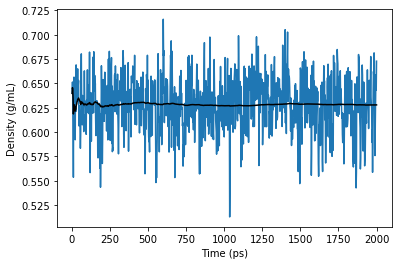

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('scalars_solvent.csv')
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print("The experimental saturated liquid density of acetonitril at 423.52K: 0.626303 g/ml")
print(f"The average density at convergion is: {ma_data[-1]}")
print(f"The absolute difference between obtained and experimental density is:{abs(ma_data[-1]-0.626303)}")
plt.show()

The average volume at convergion is: 7.615033157716915


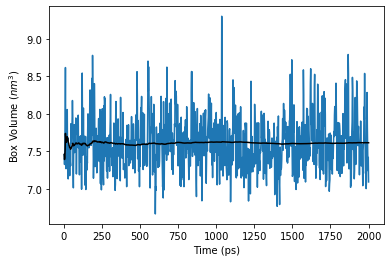

In [58]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
plt.show()

### Solutes in acetonitril solvent box

The average density at convergion is: 0.6670630771310382


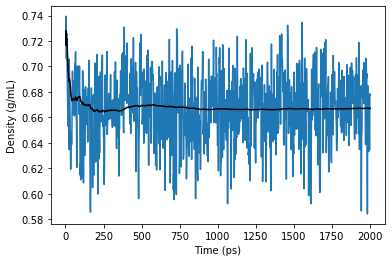

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('scalars.csv')
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 8.124206682935302
The box dimensions for a NVT simulation should hence be: 20.102974472088718


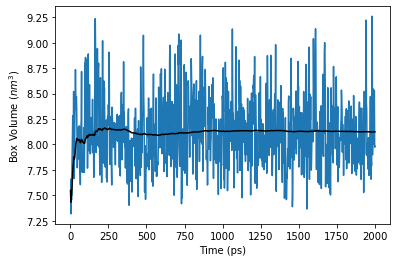

In [65]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*10)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()